# Generando Moléculas con MolGAN

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Para resumir, los pasos que hemos seguido han sido:

* Descargamos, cargamos y extraemos los SMILES strings del tox21 dataset
* Especificamos el número máximo de átomos para codificar en el featurizador y la red MolGAN
* Inicializamos el featurizador
* Filtramos las moléculas con muchos átomos
* Featurizamos las moléculas de nuestros datos
* Removemos moléculas invalidas (que no sean de tipo GraphMatrix)
* Inicializamos el modelo MolGAN
* Creamos un dataset en el formato de la entrada a MolGAN de nuestros datos featurizados
* Definimos la función de iterbatches (generador de lotes)
* Entrenamos en modelo con la función fit_gan y generamos moléculas con el predict_gan_generator

**NOTA:** En la red MolGAN hacemos uso de una WGAN en vez de una GAN. La diferencia principal entre los dos radica en el discriminador (a menudo llamado "crítico" en este contexto). En lugar de producir la probabilidad de que una muestra sea datos de entrenamiento reales, intenta aprender cómo medir la distancia entre la distribución de entrenamiento y la distribución generada. Esa medida se puede utilizar directamente como función de pérdida para entrenar el generador.

En este tutorial, entrenaremos una red MolGAN en el conjunto de datos tox21, que consta de 12,060 muestras de entrenamiento y 647 muestras de prueba de compuestos químicos. La red MolGAN fue introducida por primera vez en "MolGAN: An implicit generative model for small molecular graphs" por Cao y Kipf. Utiliza una GAN directamente en datos de grafos y un objetivo de aprendizaje por refuerzo para inducir a la red a generar moléculas con ciertas propiedades químicas.

La arquitectura consta de 3 secciones principales: un generador, un discriminador y una red de recompensa.

El generador toma una muestra (z) de una distribución normal estándar para generar un grafo utilizando una MLP (Multi-Layer Perceptron) (esto limita la red a un tamaño máximo fijo) para generar el grafo de una vez. Específicamente, se producen un tensor de adyacencia denso A (enlace) y una matriz de anotación X (átomos). Dado que son probabilidades, se generan x y a discretos y dispersos a través de un muestreo categórico.

El discriminador y la red de recompensa tienen las mismas arquitecturas y reciben grafos como entradas. Se utiliza un Relational-GCN y MLPs para producir la salida singular.


En la imagen de abajo podemos ver el generador que produce un tensor de adyacencia A (enlaces) y un tensor de adyacencia X (atomos). Luego se escogen muestras de cada una de los tensores y se transforma en un grafo (representación de la molécula que será enviada al discriminador y a la red de recompensas

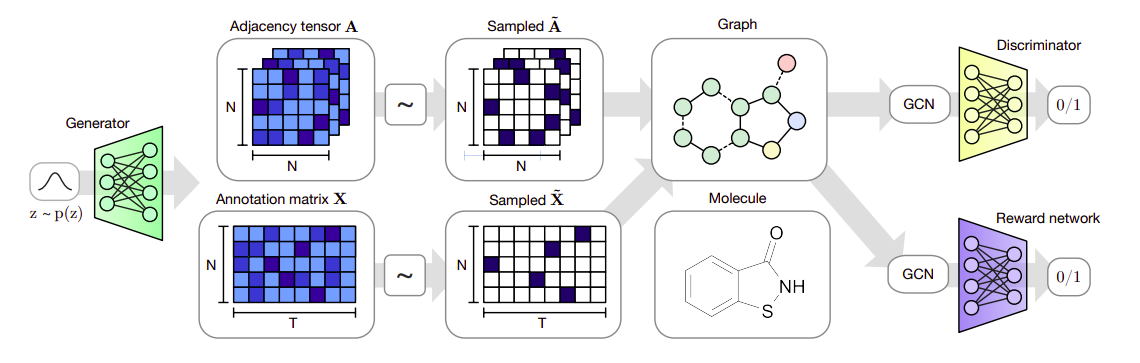

In [2]:
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\alloh\miniconda3\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Descargamos, cargamos y extraemos los SMILES strings del tox21 dataset

In [42]:
# Download from MolNet
# Try tox21 or LIPO dataset
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [43]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


Especifica el número máximo de átomos para codificar en el featurizador y la red MolGAN. Cuanto mayor sea el número de átomos, más datos tendrás en el conjunto de datos. Sin embargo, esto también aumenta la complejidad del modelo, ya que las dimensiones de entrada se vuelven más altas.


In [44]:
num_atoms = 12

In [45]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [46]:
#data = df[['smiles']].sample(4000, random_state=42)
data = df

In [47]:
data

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


Inicializa el featurizador con el número máximo de átomos por molécula. `atom_labels` es un parámetro para pasar el número atómico de los átomos que deseas poder analizar.

* 0 podría representar un átomo hipotético o un átomo no especificado.
* 5 podría representar el boro.
* 6 podría representar el carbono.
* 7 podría representar el nitrógeno.
* 8 podría representar el oxígeno.
* 9 podría representar el flúor.
* 11 podría representar el sodio.
* 12 podría representar el magnesio.
* 13 podría representar el aluminio.
* 14 podría representar el silicio.

Al igual que el parámetro `num_atoms` mencionado anteriormente, más `atom_labels` significan más datos, aunque el modelo se vuelve más complejo/inestable.


In [48]:
# create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

In [49]:
smiles = data['smiles'].values #Array con los distintos smiles 

Filtramos las moleculas con muchos átomos para reducir el número de mensajes de error

In [50]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

[19:59:58] WARNING: not removing hydrogen atom without neighbors


In [51]:
len(filtered_smiles)

2081

In [52]:
# featurize molecules
features = feat.featurize(filtered_smiles)

Failed to featurize datapoint 0, CC(O)(P(=O)(O)O)P(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 11, O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]. Appending empty array
Exception message: 20
[20:00:00] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 12, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 1
Failed to featurize datapoint 14, [I-].[K+]. Appending empty array
Exception message: 19
Failed to featurize datapoint 17, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 25, ClCOCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 27, [Cu]I. Appending empty array
Exception message: 29
Failed to featurize datapoint 32, BrCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 33, CCC(Cl)CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 39, NC(=S)NNC(N)=S. Appending empty array
Exception mess

Exception message: 27
Failed to featurize datapoint 1982, Cn1sccc1=O. Appending empty array
Exception message: 16
Failed to featurize datapoint 1983, Cn1sc(Cl)cc1=O. Appending empty array
Exception message: 17
Failed to featurize datapoint 1984, Cc1c[nH]c(=S)[nH]c1=O. Appending empty array
Exception message: 16
Failed to featurize datapoint 1985, Cc1cc(=O)[nH]c(=S)[nH]1. Appending empty array
Exception message: 16
Failed to featurize datapoint 1986, O=c1cc[nH]c(=S)[nH]1. Appending empty array
Exception message: 16
Failed to featurize datapoint 1987, CCCc1cc(=O)[nH]c(=S)[nH]1. Appending empty array
Exception message: 16
Failed to featurize datapoint 1998, O=C1CCC(=O)N1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 2008, Cl[C@H]1OCCO[C@@H]1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 2011, Sc1nnc(S)s1. Appending empty array
Exception message: 16
Failed to featurize datapoint 2024, O=c1[nH]sc2ccccc12. Appending empty array
Ex

Removemos moléculas invalidas (que no sean de tipo GraphMatrix)

In [53]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ] #Nos quedamos con los indices de las moleculas validas
features = [features[i] for i in indices] #Filtramos por dichos indices

In [54]:
len(features)

1371

Inicializamos el modelo MolGAN y establecemos la tasa de aprendizaje y el numero máximo de átomos como el tamaño de los vértices. Despues, creamos un dataset en el formato de la entrada a MolGAN

In [55]:
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

Definimos la función de iterbatches ya que gan_fit requiere un iterable para los lotes.

In [56]:
#Función que nos va a generar los distintos lotes de datos con un tamaño determinado.
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

Entrenamos en modelo con la función fit_gan y generamos moléculas con el predict_gan_generator

In [57]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 349: generator average loss -4.39193, discriminator average loss -13.0599
TIMING: model fitting took 73.210 s
Generating 1000 samples


In [1]:
generated_data = gan.predict_gan_generator(1000)

NameError: name 'gan' is not defined

Para entrenar la GAN hacemos uso de fit_gan que tiene varios argumentos. 
* Nuestro generador de lotes con 25 épocas
* Especificamos "generator_steps=0.2" para que el generador solo realice un paso de entrenamiento por cada cinco pasos de   entrenamiento del discriminador. Esto tiende a acelerar el entrenamiento y producir mejores resultados (En las WGANS, en las GANs simples tendemos a tener un aprendizaje equilibrado entre generador y discriminador. En la WGANS, cuando mejor sea el discriminador, mejor tasa de aprendizaje tendrá el generador)
* Guardamos el modelo de la GAN cada 5000 pasos de entrenamiento

Luego pasamos a generar los datos que los almacenaremos en la variable *generated_data* y donde generaremos 1000 muestras

Convertimos los gráficos generados a RDKit moleculas

In [58]:
nmols = feat.defeaturize(generated_data) #Realizamos la defeturarización de nuestras moléculas generadas para poder representarlas

[20:01:25] Explicit valence for atom # 0 C, 14, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 12, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 0 C, 11, is greater than permitted
[20:01:25] Explicit valence for atom # 

In [59]:
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


Removemos las moléculas inválidas de la lista

In [60]:
nmols = list(filter(lambda x: x is not None, nmols))

Imprimimos el número de moléculas válidas. El entrenamiento puede ser inestable por lo que el número puede variar significativamente

In [61]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

320 valid molecules


Removemos las moléculas duplicadas

In [62]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

42 unique valid molecules


In [63]:
img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)

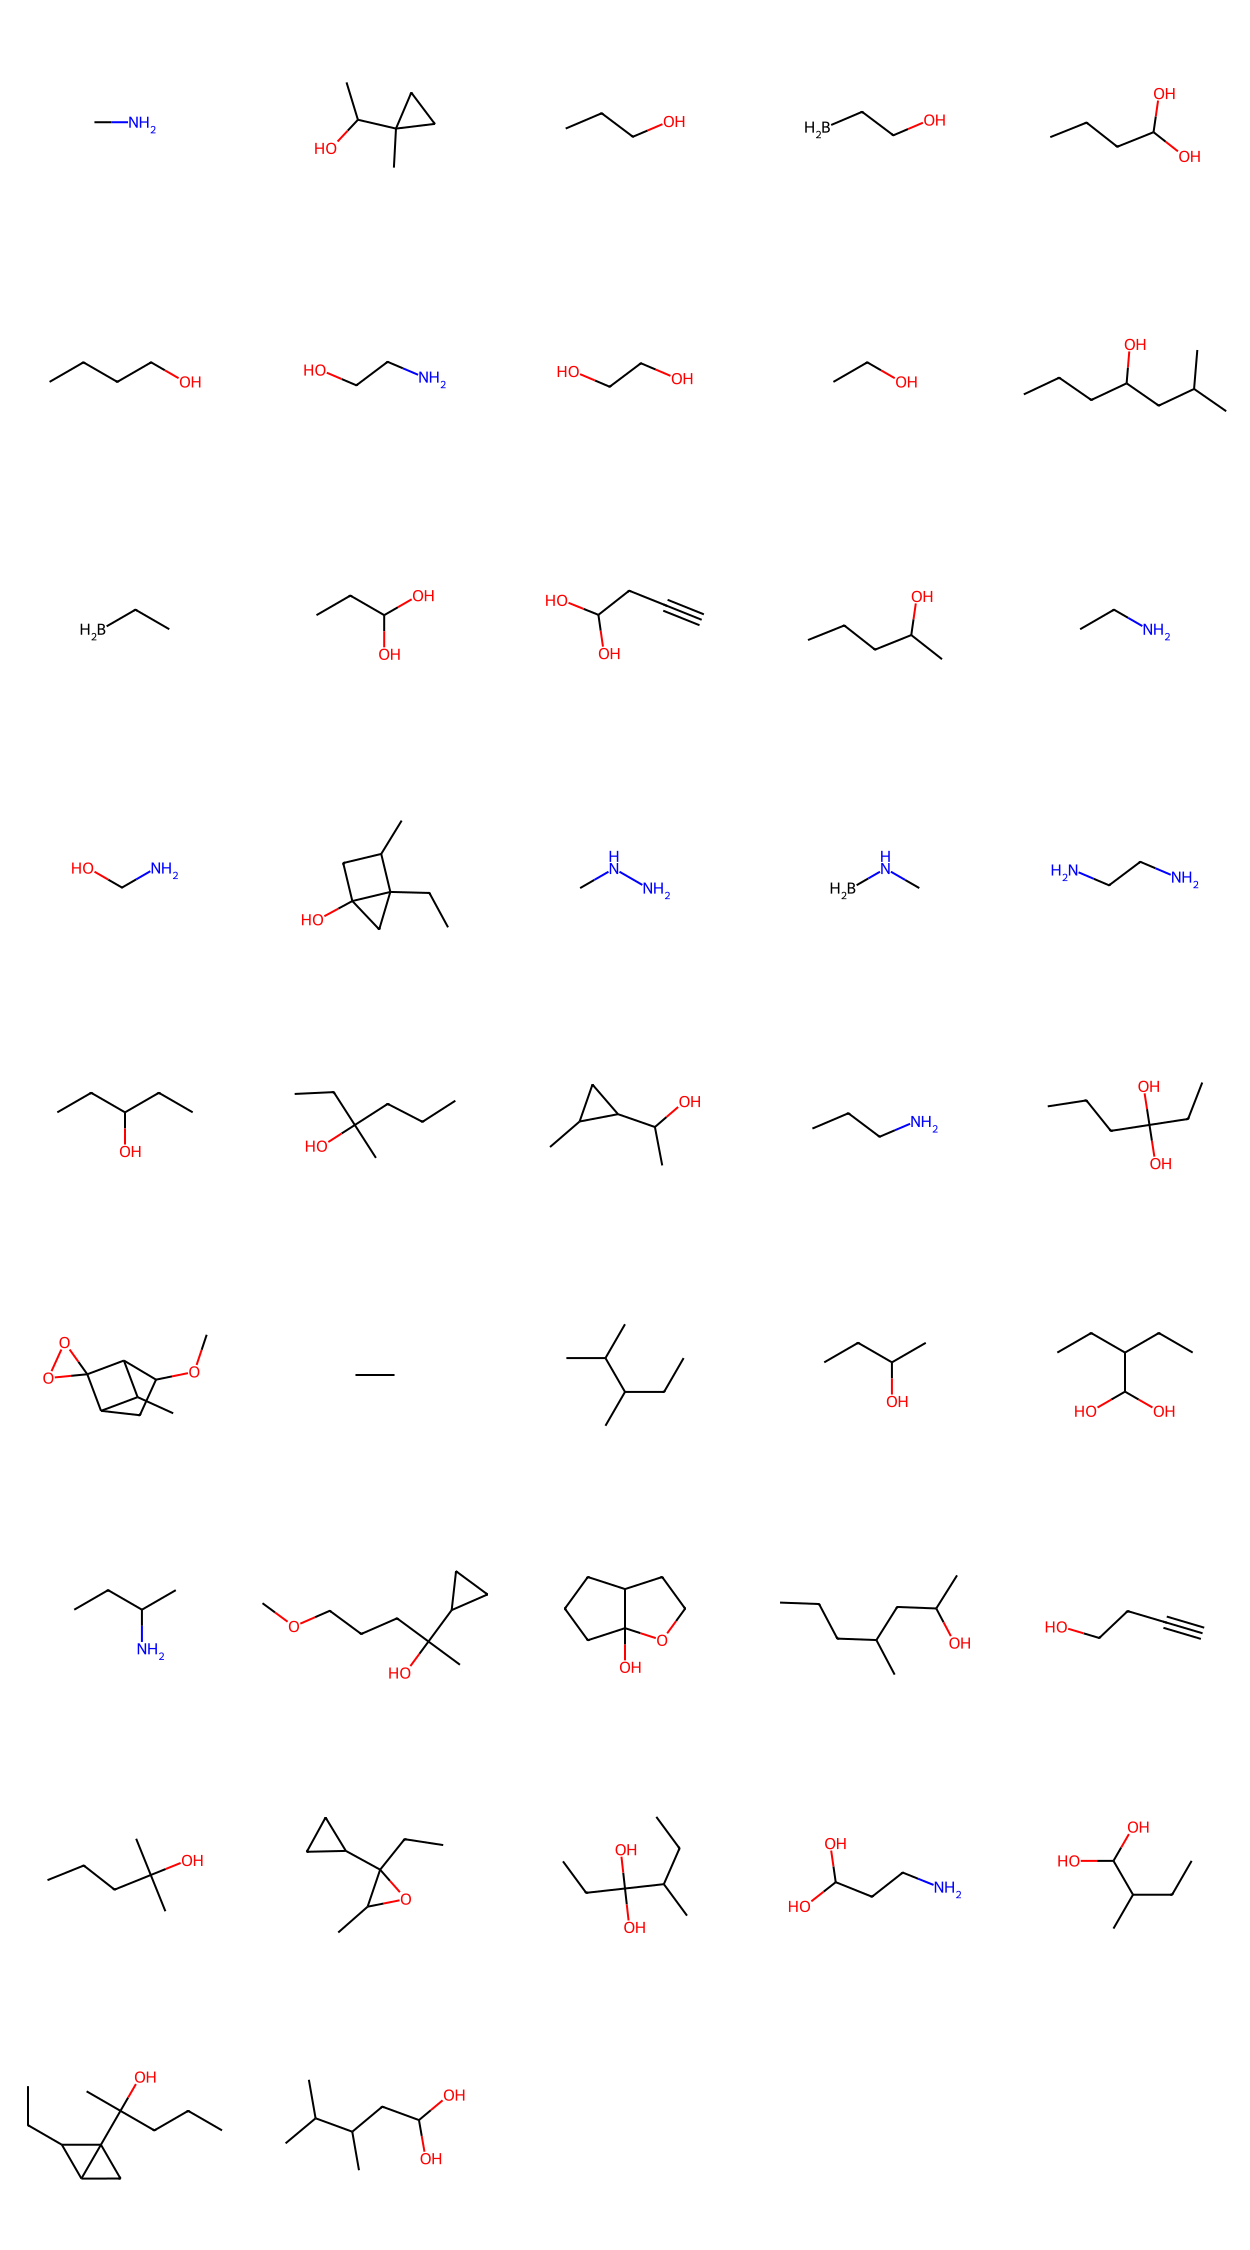

In [64]:
img #Representamos las moléculas generadas.

### Para resumir, los pasos que hemos seguido han sido:

* Descargamos, cargamos y extraemos los SMILES strings del tox21 dataset
* Especificamos el número máximo de átomos para codificar en el featurizador y la red MolGAN
* Inicializamos el featurizador
* Filtramos las moléculas con muchos átomos
* Featurizamos las moléculas de nuestros datos
* Removemos moléculas invalidas (que no sean de tipo GraphMatrix)
* Inicializamos el modelo MolGAN
* Creamos un dataset en el formato de la entrada a MolGAN de nuestros datos featurizados
* Definimos la función de iterbatches (generador de lotes)
* Entrenamos en modelo con la función fit_gan y generamos moléculas con el predict_gan_generator
